<a href="https://colab.research.google.com/github/kowshikkumarb/COVID19-Pneumonia-Detection/blob/main/P535_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from keras.preprocessing import image
#from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization # Changed the import statement for BatchNormalization
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical # Use to_categorical directly from tensorflow.keras.utils
from keras.layers import Dense
from keras import optimizers
from keras import backend as K
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Flatten, AveragePooling2D, Dropout
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop

In [7]:
import tensorflow as tf

In [8]:
!pip install kaggle
#Goto your Kaggle profile download your API key as "kaggle.json" and upload here
from google.colab import files
files.upload();

Saving kaggle.json to kaggle.json


In [9]:
#Make a directory named kaggle and copy the kaggle.json file there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# change the permission of the file
!chmod 600 ~/.kaggle/kaggle.json
#download dataset from kaggle
!kaggle datasets download -d preetviradiya/covid19-radiography-dataset
#unzip file
from zipfile import ZipFile
file_name = 'covid19-radiography-dataset.zip'
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Dataset URL: https://www.kaggle.com/datasets/preetviradiya/covid19-radiography-dataset
License(s): GPL-2.0
 99% 737M/747M [00:12<00:00, 37.3MB/s]
100% 747M/747M [00:12<00:00, 62.0MB/s]
Done


In [11]:
import os
import skimage.io as io
import skimage.color as color
import skimage.transform as trf
import numpy as np

path = "/content/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset"
images = []
labels = []
for directory in sorted(os.listdir(path)):
        data_path = path +"/"+ directory
        for im in os.listdir(data_path)[:]:
            image = io.imread(f"{data_path}/{im}")
            # Check if the image is already grayscale
            if len(image.shape) == 3 and image.shape[2] == 3:
                image = color.rgb2gray(image)
            image = trf.resize(image, (64, 64))
            images.append(image)
            labels.append(directory)

images = np.array(images)
labels = np.array(labels)
images.shape

(21165, 64, 64)

In [12]:
#subset COVID and Normal images & binary labels
index = []
l = []
for i in range(len(labels)):
    if not (labels[i] == "COVID" or labels[i] == "Normal"):
      index.append(i)
    elif labels[i] == "COVID":
      l.append(1)
    elif labels[i] == "Normal":
      l.append(0)

labels = np.delete(labels, index)
images = np.delete(images, index, 0)
images.shape
lab = np.array(l)

In [13]:
lab

array([1, 1, 1, ..., 0, 0, 0])

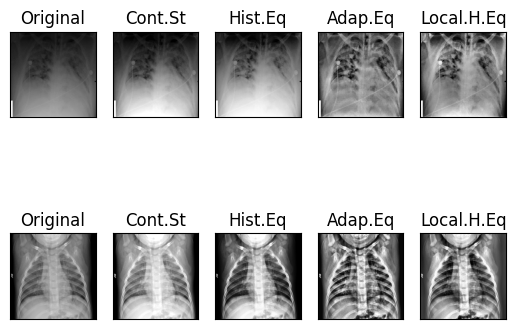

In [16]:
#Image processing tools comparision
import matplotlib.pyplot as plt
from skimage.filters.rank import equalize
from skimage.morphology import disk
import skimage.exposure as ex
import skimage.io as io
import skimage.color as color

# Load the image using io.imread
img1 = io.imread("/content/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/COVID/COVID-102.png")

# Check the number of dimensions of the image
if len(img1.shape) == 3 and img1.shape[2] == 3:
    # Convert to grayscale if the image has 3 channels
    img1 = color.rgb2gray(img1)
elif len(img1.shape) == 2:
    # Image is already grayscale
    pass
else:
    # Raise an error if the image format is not recognized
    raise ValueError("Image format not recognized. Expected grayscale or RGB image.")

# Load the image and check its dimensions
img2 = io.imread("/content/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/Normal/Normal-1000.png")
if len(img2.shape) == 3 and img2.shape[2] == 3:
    img2 = color.rgb2gray(img2)
# If the image is already grayscale, no need to convert

p2, p98 = np.percentile(img1, (2, 98))
pp2, pp98 = np.percentile(img2, (2, 98))
plt.gray()
plt.subplot(251).set_title("Original")
plt.imshow(img1)
plt.subplot(252).set_title("Cont.St")
plt.imshow(ex.rescale_intensity(img1, in_range=(p2,p98)))
plt.subplot(253).set_title('Hist.Eq')
plt.imshow(ex.equalize_hist(img1))
plt.subplot(254).set_title("Adap.Eq")
plt.imshow(ex.equalize_adapthist(img1, clip_limit=0.03))
plt.subplot(255).set_title("Local.H.Eq")
plt.imshow(equalize(img1, disk(70)))
plt.subplot(256).set_title("Original")
plt.imshow(img2)
plt.subplot(257).set_title("Cont.St")
plt.imshow(ex.rescale_intensity(img2, in_range=(pp2,pp98)))
plt.subplot(258).set_title('Hist.Eq')
plt.imshow(ex.equalize_hist(img2))
plt.subplot(259).set_title("Adap.Eq")
plt.imshow(ex.equalize_adapthist(img2, clip_limit=0.03))
plt.subplot(2,5,10).set_title("Local.H.Eq")
plt.imshow(equalize(img2, disk(70)))
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);

In [18]:
# #Image processing tools comparision
# import matplotlib.pyplot as plt
# from skimage.filters.rank import equalize
# from skimage.morphology import disk
# import skimage.exposure as ex
# img1 = color.rgb2gray(io.imread("/content/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/COVID/COVID-102.png"))
# img2 = color.rgb2gray(io.imread("/content/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/Normal/Normal-1000.png"))
# p2, p98 = np.percentile(img1, (2, 98))
# pp2, pp98 = np.percentile(img2, (2, 98))
# plt.gray()
# plt.subplot(251).set_title("Original")
# plt.imshow(img1)
# plt.subplot(252).set_title("Cont.St")
# plt.imshow(ex.rescale_intensity(img1, in_range=(p2,p98)))
# plt.subplot(253).set_title('Hist.Eq')
# plt.imshow(ex.equalize_hist(img1))
# plt.subplot(254).set_title("Adap.Eq")
# plt.imshow(ex.equalize_adapthist(img1, clip_limit=0.03))
# plt.subplot(255).set_title("Local.H.Eq")
# plt.imshow(equalize(img1, disk(70)))
# plt.subplot(256).set_title("Original")
# plt.imshow(img2)
# plt.subplot(257).set_title("Cont.St")
# plt.imshow(ex.rescale_intensity(img2, in_range=(pp2,pp98)))
# plt.subplot(258).set_title('Hist.Eq')
# plt.imshow(ex.equalize_hist(img2))
# plt.subplot(259).set_title("Adap.Eq")
# plt.imshow(ex.equalize_adapthist(img2, clip_limit=0.03))
# plt.subplot(2,5,10).set_title("Local.H.Eq")
# plt.imshow(equalize(img2, disk(70)))
# plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);

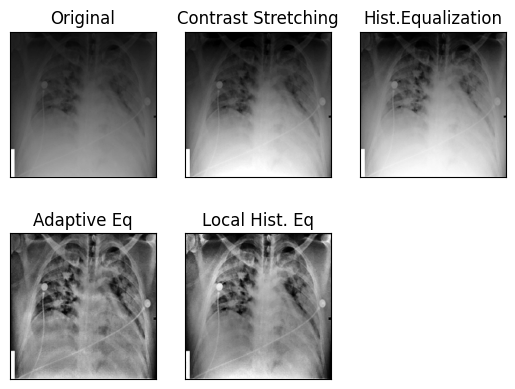

In [20]:
# Sample image pre-processing
import matplotlib.pyplot as plt
import skimage.exposure as ex
import skimage.io as io # make sure to import io
import skimage.color as color

img = io.imread("/content/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/COVID/COVID-102.png")

# Check if the image is already grayscale
if len(img.shape) == 2:
  # Image is already grayscale
  pass
elif len(img.shape) == 3 and img.shape[2] == 3:
  # Convert to grayscale if the image has 3 channels
  img = color.rgb2gray(img)
else:
  # Raise an error if the image format is not recognized
  raise ValueError("Image format not recognized. Expected grayscale or RGB image.")

p2, p98 = np.percentile(img, (2, 98))
plt.gray()
plt.subplot(231).set_title("Original")
plt.imshow(img)
plt.subplot(232).set_title("Contrast Stretching")
plt.imshow(ex.rescale_intensity(img, in_range=(p2, p98)))
plt.subplot(233).set_title('Hist.Equalization')
plt.imshow(ex.equalize_hist(img))
plt.subplot(234).set_title("Adaptive Eq")
plt.imshow(ex.equalize_adapthist(img, clip_limit=0.03))
plt.subplot(235).set_title("Local Hist. Eq")
plt.imshow(equalize(img, disk(70)))
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);

In [21]:
# # Sample image pre-processing
# import matplotlib.pyplot as plt
# import skimage.exposure as ex
# img = color.rgb2gray(io.imread("/content/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/COVID/COVID-102.png"))
# p2, p98 = np.percentile(img, (2, 98))
# plt.gray()
# plt.subplot(231).set_title("Original")
# plt.imshow(img)
# plt.subplot(232).set_title("Contrast Stretching")
# plt.imshow(ex.rescale_intensity(img, in_range=(p2, p98)))
# plt.subplot(233).set_title('Hist.Equalization')
# plt.imshow(ex.equalize_hist(img))
# plt.subplot(234).set_title("Adaptive Eq")
# plt.imshow(ex.equalize_adapthist(img, clip_limit=0.03))
# plt.subplot(235).set_title("Local Hist. Eq")
# plt.imshow(equalize(img, disk(70)))
# plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);

In [22]:
#image dataset pre-processing
images_eq = np.array([equalize(image, disk(70)) for image in images])
images_eq = np.reshape(images_eq, (13808,64,64,1),order='C')
images_eq.shape

<ipython-input-22-6206b7e2ccdc>:2: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  images_eq = np.array([equalize(image, disk(70)) for image in images])


(13808, 64, 64, 1)

In [23]:
images = np.reshape(images, (13808,64,64,1),order='C')
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, lab, test_size=0.25, random_state=1234)

In [24]:
X_test.shape

(3452, 64, 64, 1)

In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Import ImageDataGenerator from tensorflow.keras.preprocessing.image

train_datagen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255)
training_set = train_datagen.flow(X_train,y=y_train,batch_size = 32)
test_set = test_datagen.flow(X_test,y=y_test,batch_size = 32)
input_shape = (64,64,1)

In [27]:
# from keras.preprocessing.image import ImageDataGenerator

# train_datagen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
# test_datagen = ImageDataGenerator(rescale = 1./255)
# training_set = train_datagen.flow(X_train,y=y_train,batch_size = 32)
# test_set = test_datagen.flow(X_test,y=y_test,batch_size = 32)
# input_shape = (64,64,1)

In [29]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape = input_shape, activation = 'relu'))
BatchNormalization(axis=-1)
model.add(MaxPooling2D(pool_size=(2,2)))
BatchNormalization(axis=-1)
model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
BatchNormalization(axis=-1)
model.add(MaxPooling2D(pool_size=(2,2)))# Fully connected layer
model.add(Flatten())
BatchNormalization()
model.add(Dense(512))
model.add(Activation('relu'))
BatchNormalization()
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation('softmax'))
opt=Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
# use model.fit instead of model.fit_generator
model.fit(training_set,  steps_per_epoch = 8000,  epochs = 25,  validation_steps = 2000)
score = model.evaluate(X_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/losses/losses.py:27: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._f

8000/8000 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step - accuracy: 0.2621 - loss: 0.0000e+00  
Epoch 2/25
   1/8000 ━━━━━━━━━━━━━━━━━━━━ 23:06 173ms/step - accuracy: 0.2812 - loss: 0.0000e+00

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


8000/8000 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.2620 - loss: 0.0000e+00   
Epoch 3/25
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 8s 954us/step - accuracy: 0.2618 - loss: 0.0000e+00 
Epoch 4/25
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.2619 - loss: 0.0000e+00   
Epoch 5/25
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.2619 - loss: 0.0000e+00  
Epoch 6/25
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 9s 965us/step - accuracy: 0.2622 - loss: 0.0000e+00 
Epoch 7/25
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 11s 980us/step - accuracy: 0.2619 - loss: 0.0000e+00
Epoch 8/25
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.2620 - loss: 0.0000e+00   
Epoch 9/25
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - accuracy: 0.2621 - loss: 0.0000e+00   
Epoch 10/25
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 9s 913us/step - accuracy: 0.2619 - loss: 0.0000e+00 
Epoch 11/25
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 10s 927us/step - accuracy: 0.2622 - loss: 0.0000e+00
Epoch 12/25
8000/8000 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - ac

In [30]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 62, 62, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 29, 29, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       6,423,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             513 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,327,109 (73.73 MB)

 Trainable params: 6,442,369 (24.58 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 12,884,740 (49.15 MB)

In [ ]:
# # # Model design
# epochs = 100
# batch_size = 32
# #
# # # Initialising the CNN
# model = Sequential()

# # # Convolution
# model.add(Conv2D(32, (3, 3), input_shape = input_shape, activation = 'relu'))

# # # Pooling
# model.add(MaxPooling2D(pool_size = (2, 2)))

# # # Second convolutional layer
# model.add(Conv2D(32, (3, 3), activation = 'relu'))
# model.add(MaxPooling2D(pool_size = (2, 2)))

# # # Flattening
# model.add(Flatten())

# # # Full connection
# model.add(Dense(units = 128, activation = 'relu'))
# model.add(Dense(units = 1, activation = 'softmax'))

# # # Compiling the CNN
# opt=Adam(learning_rate=0.01)
# model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
# #model.fit(training_set, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.2)
# model.fit_generator(training_set,  steps_per_epoch = 80,  epochs = 25,  validation_steps = 20)

In [28]:
# model = Sequential()
# model.add(Conv2D(32, (3, 3), input_shape = input_shape, activation = 'relu'))
# BatchNormalization(axis=-1)
# model.add(MaxPooling2D(pool_size=(2,2)))
# BatchNormalization(axis=-1)
# model.add(Conv2D(64,(3,3)))
# model.add(Activation('relu'))
# BatchNormalization(axis=-1)
# model.add(MaxPooling2D(pool_size=(2,2)))# Fully connected layer
# model.add(Flatten())
# BatchNormalization()
# model.add(Dense(512))
# model.add(Activation('relu'))
# BatchNormalization()
# model.add(Dropout(0.2))
# model.add(Dense(1))
# model.add(Activation('softmax'))
# opt=Adam(learning_rate=0.01)
# model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
# model.fit_generator(training_set,  steps_per_epoch = 8000,  epochs = 25,  validation_steps = 2000)
# score = model.evaluate(X_test, y_test)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


AttributeError: 'Sequential' object has no attribute 'fit_generator'

In [ ]:
#data augmentation

#flip_images = np.flip(images, axis=2)
#bright_images =  np.array([ex.adjust_gamma(image, gamma=0.5 ,gain=1) for image in images])
#dark_images =  np.array([ex.adjust_gamma(image, gamma=1.5 ,gain=1) for image in images])

#images = np.concatenate([images, flip_images, bright_images, dark_images])
#labels = np.concatenate([labels, labels, labels, labels])

In [ ]:
# !pip install split_folders


In [ ]:
# import splitfolders

# import os

In [ ]:
# cd content/gdrive/My Drive/COVID-19_Radiography_Dataset/

In [ ]:
# path='/content/gdrive/MyDrive/COVID-19_Radiography_Dataset'

In [ ]:
#datagen = ImageDataGenerator(rotation_range=20, zoom_range=0.15, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15, horizontal_flip=True, fill_mode="nearest", rescale=1./255, validation_split=0.3)



#training_set = datagen.flow_from_directory(images_data, target_size = (255, 255), batch_size = 16, class_mode = 'categorical', shuffle=True)

#test_set = datagen.flow_from_directory(images_data ,target_size = (255, 255),batch_size = 16,class_mode = 'categorical',shuffle = False)

In [ ]:
# classes=["COVID", "Lung_Opacity", "Normal", "Viral Pneumonia"]
# #classes=["COVID",  "Normal"]
# num_classes = len(classes)
# print(num_classes)
# batch_size=32

# #split de datagen into 70% and 30%, train and test
# datagen = ImageDataGenerator(rotation_range=20, zoom_range=0.15, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15, horizontal_flip=True, fill_mode="nearest", rescale=1./255, validation_split=0.3)

# #load the images to training
# train_gen = datagen.flow_from_directory(directory=path,
#                                               target_size=(256, 256),
#                                               class_mode='categorical',
#                                               subset='training',
#                                               shuffle=True, classes=classes,
#                                               batch_size=batch_size,
#                                               color_mode="grayscale")
# #load the images to test
# test_gen = datagen.flow_from_directory(directory=path,
#                                               target_size=(256, 256),
#                                               class_mode='categorical',
#                                               subset='validation',
#                                               shuffle=True, classes=classes,
#                                               batch_size=batch_size,
#                                               color_mode="grayscale")

# def model1():

#     model = Sequential()
#     model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)))
#     model.add(Conv2D(32, (3, 3), activation='relu'))
#     model.add(MaxPooling2D((2, 2)))
#     model.add(Conv2D(64, (3, 3), activation='relu'))
#     model.add(Conv2D(64, (3, 3), activation='relu'))
#     model.add(MaxPooling2D((2, 2)))
#     model.add(Conv2D(128, (3, 3), activation='relu'))
#     model.add(Conv2D(128, (3, 3), activation='relu'))
#     model.add(MaxPooling2D((2, 2)))
#     model.add(Flatten())
#     model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
#     model.add(Dense(num_classes, activation='sigmoid'))
#     # compile model
#     opt = SGD(lr=0.01, momentum=0.9)
#     model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["accuracy"])
#     model.summary()
#     return model